## Comparing two SST products and their associated uncertainties: NOAA GDP and MUR

The first goal of the activity is to compare two SST estimate products: The Global Drifter Program hourly SST product [Elipot et al. 2022](https://dx.doi.org/10.1038/s41597-022-01670-2) and the Multi-scale Ultra-high Resolution (MUR) SST analysis [Chin et al. 2017](https://doi.org/10.1016/j.rse.2017.07.029), a product mostly based on satellite SST data. Each product also reports associated measures of uncertainty - the second goal of this activity is to interpret these uncertainties and use them in the comparison. Please refer to these respective papers for further details about these datasets. 

### Learning Outcomes
After this computer lab session you should be able to
- perform statistical comparisons of two datasets measuring the same quantity
- interpret uncertainty estimates and use them to establish if datasets are significantly different from each other

#### Preliminary: load the matched up dataset of SST values from both products, and do a bit of visualization 

In [1]:
# these are the packages that you will most likely need to complete the assignment
import numpy as np
# we use xarray here to open the dataset and visialize its content but you can easily work with numpy arrays instead
import xarray as xr
import matplotlib.pyplot as plt
import scipy as sp
# clouddrift is a package that is dedicated to work with Lagrangian datasets arranged as ragged array
# you may want to eventually use it for its ragged.subset function which will allow you to further filter data
import clouddrift as cd

In [2]:
# data import and display with xarray; change path as needed
# We start by opening the extracted dataset for Atlantic region, which consists of portions of drifter trajectories at hourly intervals
file = 'data/gdp_atlantic.nc'
ds = xr.open_dataset(file,decode_times=True)
ds

<xarray.Dataset> Size: 173MB
Dimensions:                (traj: 804, obs: 1799525)
Coordinates:
    id                     (traj) int64 6kB ...
    time                   (obs) datetime64[ns] 14MB ...
Dimensions without coordinates: traj, obs
Data variables: (12/62)
    BuoyTypeManufacturer   (traj) |S20 16kB ...
    BuoyTypeSensorArray    (traj) |S20 16kB ...
    CurrentProgram         (traj) float32 3kB ...
    DeployingCountry       (traj) |S20 16kB ...
    DeployingShip          (traj) |S20 16kB ...
    DeploymentComments     (traj) |S20 16kB ...
    ...                     ...
    typedeath              (traj) int8 804B ...
    ve                     (obs) float32 7MB ...
    vn                     (obs) float32 7MB ...
    mur_sst                (obs) float32 7MB ...
    mur_sst_err            (obs) float32 7MB ...
    mur_dt_1km             (obs) float64 14MB ...
Attributes: (12/16)
    Conventions:       CF-1.6
    acknowledgement:   Elipot, Shane; Sykulski, Adam; Lumpkin, Rick; Centurio...
    contributor_name:  NOAA Global Drifter Program
    contributor_role:  Data Acquisition Center
    date_created:      2023-09-08T17:05:12.130123
    doi:               10.25921/x46c-3620
    ...                ...
    processing_level:  Level 2 QC by GDP drifter DAC
    publisher_email:   aoml.dftr@noaa.gov
    publisher_name:    GDP Drifter DAC
    publisher_url:     https://www.aoml.noaa.gov/phod/gdp
    summary:           Global Drifter Program hourly data
    title:             Global Drifter Program hourly drifting buoy collection

In [3]:
# the data are organized as ragged arrays, see https://clouddrift.org for more information. For this activity you may not need to worry about this. 
# The variables you will be first working with are sst, err_sst, flg_sst, mur_sst, mur_sst_err.

# unpack the trajectory data into lists for easier plotting
from clouddrift.ragged import unpack

id = unpack(ds["id"],rowsize=ds["rowsize"])
time = unpack(ds["time"],rowsize=ds["rowsize"])
sst = unpack(ds["sst"],rowsize=ds["rowsize"])
err_sst = unpack(ds["err_sst"],rowsize=ds["rowsize"])
sst_mur = unpack(ds["mur_sst"],rowsize=ds["rowsize"])
err_sst_mur = unpack(ds["mur_sst_err"],rowsize=ds["rowsize"])


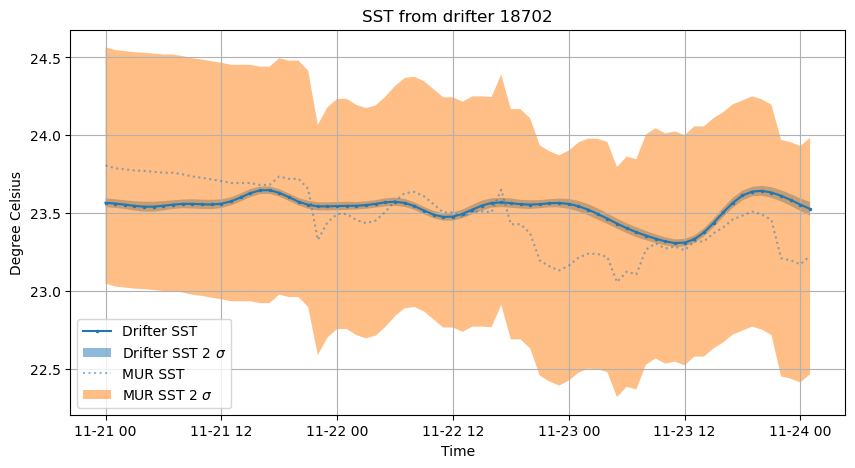

In [4]:
# plot some of the data
# note the difference in magnitude between the two SST uncertainty estimates
m = 1
offset = 273.15
plt.figure(figsize=(10, 5))
hc = plt.plot(time[m], sst[m] - offset,marker = '.',markersize=3)
plt.fill_between(time[m], sst[m]-2*err_sst[m] - offset, sst[m]+2*err_sst[m] - offset, alpha=0.5)
plt.plot(time[m], sst_mur[m] - offset, color=hc[0].get_color(),alpha=0.5,linestyle=':')
plt.fill_between(time[m], sst_mur[m]-2*err_sst_mur[m] - offset, sst_mur[m]+2*err_sst_mur[m] - offset, alpha=0.5)
plt.legend([r'Drifter SST',r'Drifter SST 2 $\sigma$','MUR SST',r'MUR SST 2 $\sigma$'])
plt.title('SST from drifter '+str(id[0][m].values))
plt.xlabel('Time')
plt.ylabel('Degree Celsius')
plt.grid(True) 
plt.show()

In [5]:
from clouddrift.ragged import subset

# define a function that selects the 9am data points
def select_9am(arr):
                    return (arr - arr.astype("datetime64[D]")) / np.timedelta64(1, "s") == 32400

ds9 = subset(ds, {"time": select_9am}, row_dim_name="traj")
ds9

<xarray.Dataset> Size: 7MB
Dimensions:                (traj: 797, obs: 74921)
Coordinates:
    id                     (traj) int64 6kB 26656 18702 ... 300534061551870
    time                   (obs) datetime64[ns] 599kB 2002-11-24T09:00:00 ......
Dimensions without coordinates: traj, obs
Data variables: (12/62)
    BuoyTypeManufacturer   (traj) |S20 16kB ...
    BuoyTypeSensorArray    (traj) |S20 16kB ...
    CurrentProgram         (traj) float32 3kB ...
    DeployingCountry       (traj) |S20 16kB ...
    DeployingShip          (traj) |S20 16kB ...
    DeploymentComments     (traj) |S20 16kB ...
    ...                     ...
    typedeath              (traj) int8 797B ...
    ve                     (obs) float32 300kB ...
    vn                     (obs) float32 300kB ...
    mur_sst                (obs) float32 300kB 296.2 296.6 296.5 ... 297.3 296.7
    mur_sst_err            (obs) float32 300kB 0.38 0.37 0.37 ... 0.38 0.38 0.39
    mur_dt_1km             (obs) float64 599kB ...
Attributes: (12/16)
    Conventions:       CF-1.6
    acknowledgement:   Elipot, Shane; Sykulski, Adam; Lumpkin, Rick; Centurio...
    contributor_name:  NOAA Global Drifter Program
    contributor_role:  Data Acquisition Center
    date_created:      2023-09-08T17:05:12.130123
    doi:               10.25921/x46c-3620
    ...                ...
    processing_level:  Level 2 QC by GDP drifter DAC
    publisher_email:   aoml.dftr@noaa.gov
    publisher_name:    GDP Drifter DAC
    publisher_url:     https://www.aoml.noaa.gov/phod/gdp
    summary:           Global Drifter Program hourly data
    title:             Global Drifter Program hourly drifting buoy collection

For this activity, we suggest for you to get started with this subset of the data, that is only the 9:00am UTC data both for the drifters and the MUR estimates.

#### Question 1:	

Investigate the differences between the drifter SST data and the MUR SST data at the drifter locations. As examples, plot visual comparisons such as scatter plots, 2-d histograms and Q-Q plots comparing the two and discuss properties you can infer from these plots.

In [41]:
# from there on we suggest that you use numpy arrays and treat the data independlt of their trajectory of origin. 
# Effectively, we are treating the data at 24 intervals at 9:00am from the different trajectories as independent samples.
offset = 273.15 # to work with degree celsius
sst = ds9['sst'].values - offset
err_sst = ds9['err_sst'].values
flg_sst = ds9['flg_sst'].values

mur_sst = ds9['mur_sst'].values - offset
mur_sst_err = ds9['mur_sst_err'].values


In [42]:
# Use the data quality flag for SST from drifters and choose data only with quality flag 4 and 5, see Elipot et al. 2022
a = flg_sst < 5

sst = sst[~a]
err_sst = err_sst[~a]
mur_sst = mur_sst[~a]
mur_sst_err = mur_sst_err[~a]

Text(0.5, 1.0, '2D histogram')

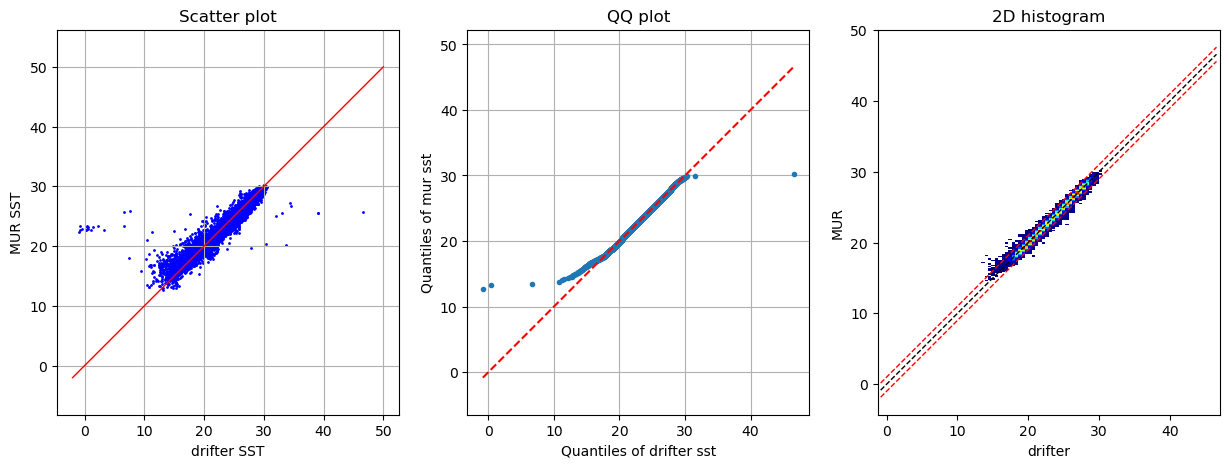

In [43]:
import matplotlib as mpl
from matplotlib.colors import ListedColormap

# scatter plot, qq plot, and 2d histogram
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].scatter(sst, mur_sst, c='b', s=1)
axs[0].plot([-2, 50], [-2, 50], linewidth=1, color='r')
axs[0].set_xlabel('drifter SST')
axs[0].set_ylabel('MUR SST')
axs[0].set_title('Scatter plot')
axs[0].axis('equal')
axs[0].grid(True)

# qq plot
quantiles = np.linspace(0, 100, 10000)  # 100 quantile levels between 0% and 100%
x_quantiles = np.percentile(sst, quantiles)
y_quantiles = np.percentile(mur_sst, quantiles)

axs[1].plot(x_quantiles, y_quantiles, marker='.', linestyle='none')
min_val = min(min(x_quantiles), min(y_quantiles))
max_val = max(max(x_quantiles), max(y_quantiles))
axs[1].plot([min_val, max_val], [min_val, max_val], 'r--')
axs[1].axis('equal')
axs[1].set_xlabel('Quantiles of drifter sst')
axs[1].set_ylabel('Quantiles of mur sst')
axs[1].set_title('QQ plot')
axs[1].grid(True)

# 2D histogram
# Get the original 'jet' colormap
jet = mpl.colormaps['jet']
# Create a new colormap from the jet colormap
newcolors = jet(np.linspace(0, 1, 256))
# Change the first color to white
newcolors[0, :] = np.array([1, 1, 1, 1])  # RGBA for white
# Create a new ListedColormap object with the modified colors
new_jet = ListedColormap(newcolors)

# cuttoff for eliminating outliers?
cutoff = 1

axs[2].hist2d(sst, mur_sst, bins=100, cmap=new_jet);
axs[2].plot([sst.min(), sst.max()], [sst.min(), sst.max()], linewidth=1, color='k', linestyle='--')
axs[2].plot([sst.min(), sst.max()], [min(sst) + cutoff, max(sst) + cutoff], linewidth=1, color='r', linestyle='--')
axs[2].plot([sst.min(), sst.max()], [min(sst) - cutoff, max(sst) - cutoff], linewidth=1, color='r', linestyle='--')
axs[2].set_xlim(sst.min(), sst.max())
axs[2].set_ylim(sst.min(), sst.max())
axs[2].set_xlabel('drifter')
axs[2].set_ylabel('MUR')
axs[2].axis('equal')
axs[2].set_title('2D histogram')

#### Question 2:	

You may notice that there are some large outliers in the drifter SST data. As the drifter SST uncertainties are significantly smaller than the MUR SST uncertainties, we will initially make the (probably incorrect) assumption that the drifters are given us the true SST data. To advance the comparison, we suggest removing any significantly outlying SST drifter data:  First use the flag information to select drifter data with quality flag 4 or more, and further remove the remaining outliers and apply a cutoff based on the data difference. Please experiment with this cutoff: 1 or 2 K or anything else. Redo the plots in Question 1 to check if outliers are removed. What percentage of the data are eliminated as such?


Text(0.5, 1.0, '2D histogram')

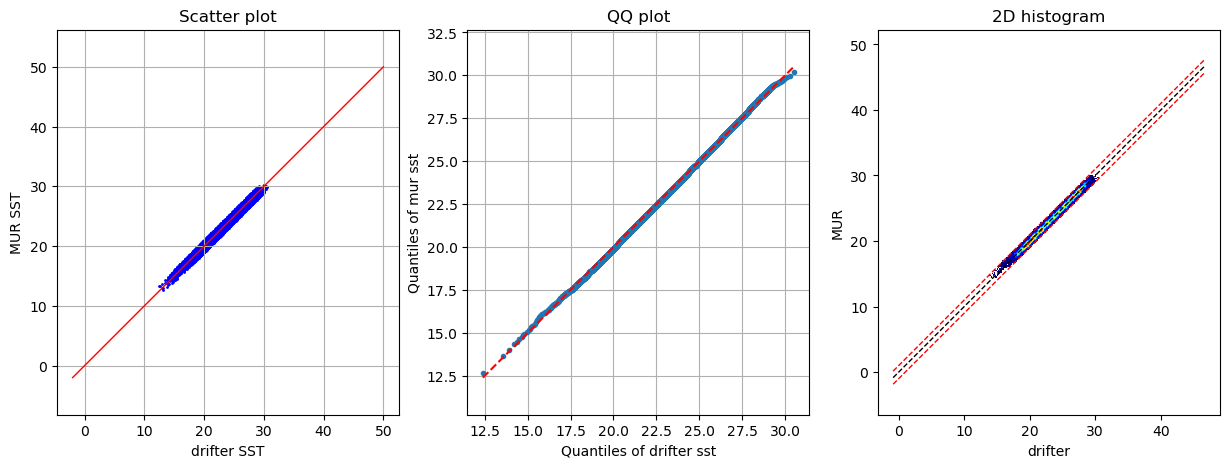

In [44]:
# cuttoff for eliminating outliers?
cutoff = 1
q = np.abs(mur_sst - sst) < cutoff

# scatter plot, qq plot, and 2d histogram
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].scatter(sst[q], mur_sst[q], c='b', s=1)
axs[0].plot([-2, 50], [-2, 50], linewidth=1, color='r')
axs[0].set_xlabel('drifter SST')
axs[0].set_ylabel('MUR SST')
axs[0].set_title('Scatter plot')
axs[0].axis('equal')
axs[0].grid(True)

# qq plot
x_quantiles = np.percentile(sst[q], quantiles)
y_quantiles = np.percentile(mur_sst[q], quantiles)

axs[1].plot(x_quantiles, y_quantiles, marker='.', linestyle='none')
min_val = min(min(x_quantiles), min(y_quantiles))
max_val = max(max(x_quantiles), max(y_quantiles))
axs[1].plot([min_val, max_val], [min_val, max_val], 'r--')
axs[1].axis('equal')
axs[1].set_xlabel('Quantiles of drifter sst')
axs[1].set_ylabel('Quantiles of mur sst')
axs[1].set_title('QQ plot')
axs[1].grid(True)

axs[2].hist2d(sst[q], mur_sst[q], bins=100, cmap=new_jet);
axs[2].plot([sst.min(), sst.max()], [sst.min(), sst.max()], linewidth=1, color='k', linestyle='--')
axs[2].plot([sst.min(), sst.max()], [min(sst) + cutoff, max(sst) + cutoff], linewidth=1, color='r', linestyle='--')
axs[2].plot([sst.min(), sst.max()], [min(sst) - cutoff, max(sst) - cutoff], linewidth=1, color='r', linestyle='--')
axs[2].set_xlim(sst.min(), sst.max())
axs[2].set_ylim(sst.min(), sst.max())
axs[2].set_xlabel('drifter')
axs[2].set_ylabel('MUR')
axs[2].axis('equal')
axs[2].set_title('2D histogram')

In [45]:
# Remove outliers for the rest of the analysis

diff_sst = mur_sst - sst  # define the difference of MUR and drifter SST

proportion_data_left = np.sum(np.abs(diff_sst) < cutoff) / len(diff_sst)
print('Proportion of data left after removing outliers:', proportion_data_left)

diff_sst = diff_sst[q]
sst = sst[q]
err_sst = err_sst[q]
mur_sst = mur_sst[q]
mur_sst_err = mur_sst_err[q]


Proportion of data left after removing outliers: 0.9674666006927264


#### Question 3:	

For this Question, assuming that the drifter SST data are the truth, let’s use those to validate the MUR SST data (and for now, ignoring the MUR uncertainty estimates provided with the MUR data). Please study the distribution of the MUR SST errors, calculated as the differences between the MUR SST data  at the drifter locations and the drifter SST data. How do you interpret this distribution and its statistical moments (mean, variance, …)?

- Plot a histogram of these errors. Overlay a normal distribution and/or plot a Q-Q plot to see if the distribution of differences are approximately Gaussian, comment whether this assumption is reasonable and see if it changes with different cutoffs used in Question 2.
- What percentage of errors fall  within 1, 2 or 3 standard deviations – comment on how and why this differs from the “68-95-99.7 rule” (that is, if the errors are Gaussian distributed then we expect this percentage of errors to lie within 1, 2 or 3 standard deviations).
- How do you interpret the mean and standard deviation of these errors?

Mean of the SST difference: -0.027478151
Standard deviation of the SST difference: 0.33038494
Percentage of error within 1 std: 0.6976090014064698
Percentage of error within 2 std: 0.945318160508034
Percentage of error within 3 std: 0.9993464887979656


<Figure size 640x480 with 0 Axes>

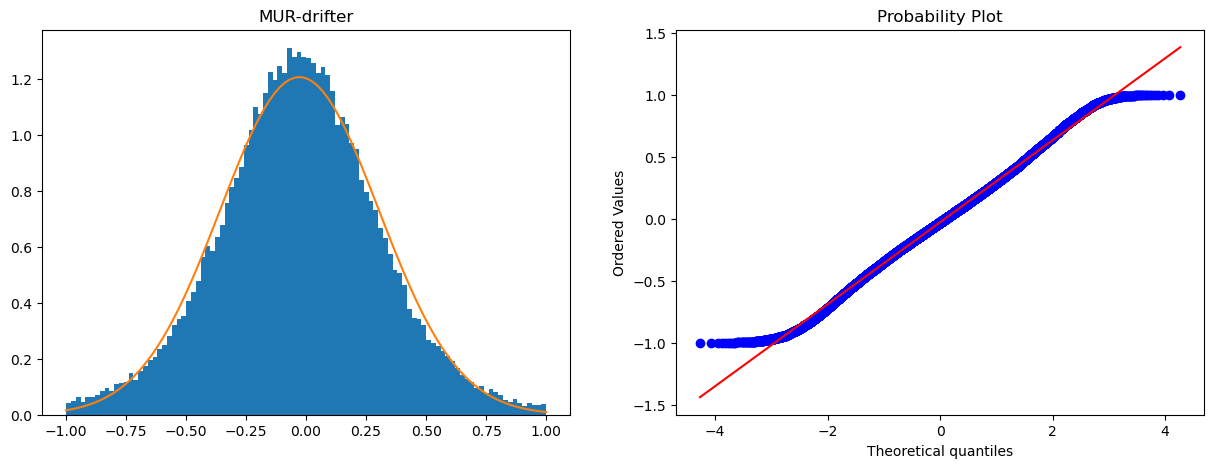

<Figure size 640x480 with 0 Axes>

In [46]:
# mean and standard deviation of the difference, considered to be the errors here
diff_sst_mean = np.mean(diff_sst)
diff_sst_std = np.std(diff_sst)

from scipy.stats import probplot

plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].hist(diff_sst, bins=100, density=True)
axs[0].plot(np.linspace(-1,1,100),sp.stats.norm.pdf(np.linspace(-1,1,100),diff_sst_mean,diff_sst_std))
axs[0].set_title('MUR-drifter')

probplot(diff_sst, dist="norm", plot=axs[1])

print('Mean of the SST difference: '+str(diff_sst_mean)) # that would be a bias
print('Standard deviation of the SST difference: '+str(diff_sst_std)) # that would be the random error? standard error; std of the errors

print('Percentage of error within 1 std: '+str(np.sum(np.abs(diff_sst)<1*diff_sst_std)/len(diff_sst)))
print('Percentage of error within 2 std: '+str(np.sum(np.abs(diff_sst)<2*diff_sst_std)/len(diff_sst)))
print('Percentage of error within 3 std: '+str(np.sum(np.abs(diff_sst)<3*diff_sst_std)/len(diff_sst)))

plt.figure()
plt.show()


#### Question 4:	

Now, taking the results above further, and still assuming the drifters tell the truth, can you :
- tell if the MUR estimates are significantly biased? Conduct a simple hypothesis test (at the 5% significance level) using either the central limit theorem or the bootstrap. 
- Define a 95% confidence interval for all MUR SST, taking into account if the bias is zero or not.

In [47]:
from scipy.stats import norm

# form the standard error of the mean (sem)
sem = diff_sst_std / np.sqrt(len(diff_sst))
# test the null hypothesis that the mean difference is zero
# 2 sided test
pval1 = 2*norm.cdf( -np.abs(diff_sst_mean)/ sem)
print('p-value of the null hypothesis that the mean difference is zero: '+str(pval1))

p-value of the null hypothesis that the mean difference is zero: 6.736764351616023e-108


Thus we reject the null hypothesis that the mean difference is zero. In other words, the test suggests that the MUR estimates are significantly biased compared to the drifter SST data. 

In [48]:
# Alternatively, use the bootstrap to recalculate MM estimates of the mean
MM = 10000
# use a python list comprehension to do the bootstrap, you can also use a for loop
mb = [np.mean(np.random.choice(diff_sst, len(diff_sst))) for _ in range(MM)]
# calculate percentiles of the bootstrap distribution, this forms a confidence interval for the mean estimate
CI95_bootstrap = np.percentile(mb, [2.5, 97.5])
print(CI95_bootstrap) 

[-0.02992956 -0.02495861]


The confidence interval based on the bootstrap shows that zero is not in it. In other words the mean difference is significant, or again, there is a significant bias.

In [50]:
# Since we found that the mean difference is not zero, we use the percentiles of the actual distribution of the "errors" to determine the confidence interval
# of the MUR SST estimates:
print(np.percentile(diff_sst, [2.5, 97.5]))
# what about defining it like this? Not the same because not exactly gaussian?
print(np.mean(diff_sst)+np.array([-1,1])*1.96*np.std(diff_sst))

[-0.70398865  0.64469299]
[-0.67503263  0.62007633]


#### Question 5: 

For this Question, consider the uncertainty estimates provided by MUR (mur_sst_err variable) which estimate the standard deviation of the estimation error in the MUR SST estimates. Study the distribution of the uncertainty estimates, and calculate their mean. How does the mean value compare to the standard deviation of the errors that you studied in Question 3 under the assumption of the drifter SST being the truth?

Unique values of MUR SST uncertainty: [0.         0.35       0.35999998 0.37       0.38       0.39
 0.39999998 0.41      ]
Mean of MUR SST uncertainty: 0.37931854


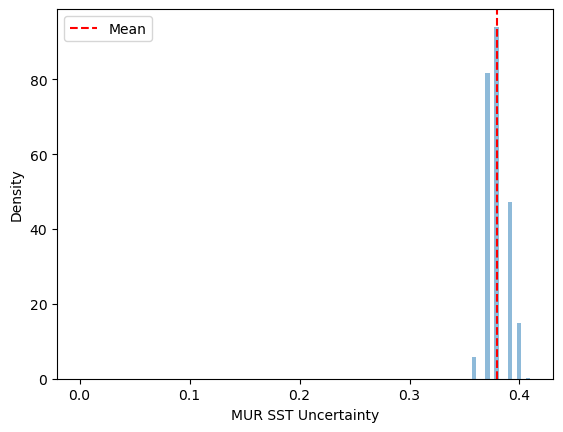

In [62]:
unique_values = np.unique(mur_sst_err)
print('Unique values of MUR SST uncertainty:', unique_values)

mur_sst_err_mean = np.mean(mur_sst_err)

# plot the histogram of MUR SST uncertainty
plt.hist(mur_sst_err, bins=100, density=True, alpha=0.5)
plt.axvline(mur_sst_err_mean, color='red', linestyle='--', label='Mean')
plt.xlabel('MUR SST Uncertainty')
plt.ylabel('Density')
plt.legend()

print('Mean of MUR SST uncertainty: '+str(mur_sst_err_mean))

In [63]:
# there seems to be some zero values in the MUR SST uncertainty
print('Number of zero uncertainty values: '+str(np.sum(mur_sst_err == 0)))


Number of zero uncertainty values: 5


#### Question 6: 

Using the MUR uncertainties, what percentage of MUR estimates fall within 1, 2 or 3 standard deviations of the corresponding drifter estimates – using the uncertainty estimates as the values of the standard deviation in your analysis. Comment on how your results differ from Q3 - is there general consistency?

In [68]:
# In other words what percentage of MUR estimates are within 1, 2, and 3 times the MUR uncertainty estimates from the drifter SST?
print(np.sum(np.abs(diff_sst)<1*mur_sst_err)/len(diff_sst))
print(np.sum(np.abs(diff_sst)<2*mur_sst_err)/len(diff_sst))
print(np.sum(np.abs(diff_sst)<3*mur_sst_err)/len(diff_sst))

0.7580587875946526
0.9708619244484223
0.9999289661736919


In [70]:
# To be compared to
print('Percentage of error within 1 std: '+str(np.sum(np.abs(diff_sst)<1*diff_sst_std)/len(diff_sst)))
print('Percentage of error within 2 std: '+str(np.sum(np.abs(diff_sst)<2*diff_sst_std)/len(diff_sst)))
print('Percentage of error within 3 std: '+str(np.sum(np.abs(diff_sst)<3*diff_sst_std)/len(diff_sst)))

Percentage of error within 1 std: 0.6976090014064698
Percentage of error within 2 std: 0.945318160508034
Percentage of error within 3 std: 0.9993464887979656


#### Question 7: 

Now look at the uncertainty estimates for the drifters (err_sst variable) which estimate the standard deviation of the estimation error in the drifter SST estimates. Study the distribution of these uncertainty estimates [suggestion: plot the logarithm of the uncertainty estimates this time], and calculate their mean. How do these values compare with the MUR uncertainties in Q5?

Mean of drifter errors: 0.027439278 or log10 : -1.5616273


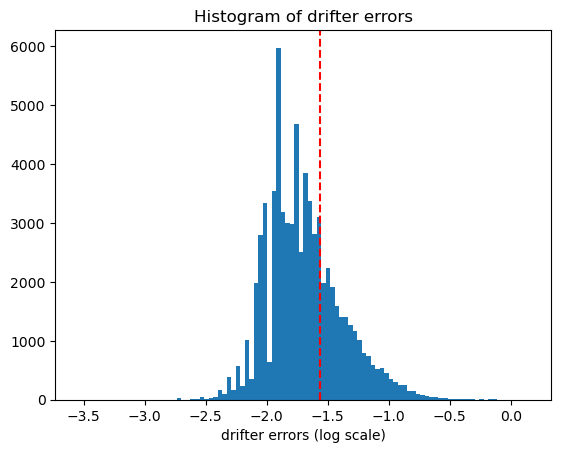

In [79]:
drifter_average_standard_error = np.mean(err_sst)

plt.figure()
plt.hist(np.log10(err_sst), bins=100)
plt.axvline(np.log10(drifter_average_standard_error), color='red', linestyle='--', label='Mean')
plt.title('Histogram of drifter errors')
plt.xlabel('drifter errors (log scale)')

print('Mean of drifter errors: '+str(drifter_average_standard_error) + ' or log10 : '+str(np.log10(drifter_average_standard_error)))

#### Question 8: 

Now let’s combine the MUR and drifter uncertainty estimates. The easiest way to do this is assume the errors in MUR and drifter estimates are independent at each location. This allows us to consider again (as in Question 3) the difference $\Delta$ between MUR and drifter estimates at each location. If the errors are independent then the uncertainty $\varepsilon(\Delta)$ of these differences can be calculated from the uncertainty products using the following formula:

$\varepsilon(\Delta)$ = $\sqrt{{\varepsilon(\text{drifter})}^2+{\varepsilon(\text{MUR})}^2}$

This formula arises because if we have two independent variables $X$ and $Y$, then $\text{Var}(X-Y) = \text{Var}(X)+\text{Var}(Y)$, and the standard deviations follow by taking the square root of each side.

Compute the mean of the uncertainties across all locations using this formula and compare with Question 5. Now repeat Question 6 and investigate what percentage of the differences between estimates fall within 1, 2 or 3 standard deviations, how have your results changed?

In [81]:
err_com = np.sqrt(err_sst ** 2 + mur_sst_err ** 2)
drifter_average_standard_error = np.mean(err_com)

prop_within_comb_err = np.sum(np.abs(diff_sst) < err_com) / len(diff_sst)
prop_within_2comb_err = np.sum(np.abs(diff_sst) < 2 * err_com) / len(diff_sst)
prop_within_3comb_err = np.sum(np.abs(diff_sst) < 3 * err_com) / len(diff_sst)

print('Mean of combined errors: '+str(drifter_average_standard_error))
print('Percentage of error within combined error: '+str(prop_within_comb_err))
print('Percentage of error within 2 combined errors: '+str(prop_within_2comb_err))
print('Percentage of error within 3 combined errors: '+str(prop_within_3comb_err))

Mean of combined errors: 0.38151798
Percentage of error within combined error: 0.7606017985764821
Percentage of error within 2 combined errors: 0.9722115671482761
Percentage of error within 3 combined errors: 0.9999431729389535


#### Question 9: 

Plot the MUR vs drifter uncertainties on a scatter plot or 2D histogram to see if independence between errors appears reasonable (again suggest plotting drifter uncertainties on log scale)

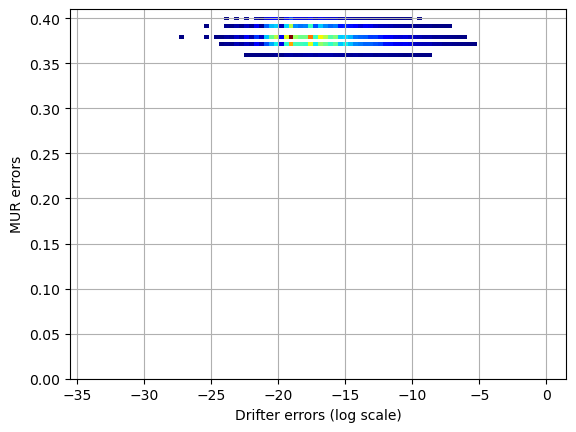

In [89]:
plt.figure()
plt.hist2d(10 * np.log10(err_sst), mur_sst_err, bins=100,cmap=new_jet)
plt.xlabel('Drifter errors (log scale)')
plt.ylabel('MUR errors')
plt.grid(True)

#### Question 10: 

Overall, would you conclude that the MUR and drifter SST estimates are approximately measuring the same quantity and do the reported uncetainties seem consistent across the datasets?

#### Bonus Challenge, Question 11: 

investigate incorporating another covariate into your analysis to see if it helps understand things further. One idea would be to look at the effect of the drifter locations and see if uncertainties and errors might vary spatially.

In [91]:
# here is an example separating drogued and undrogued drifters
ds9_drogued = subset(ds, {"time": select_9am, "drogue_status": lambda x: x == 1}, row_dim_name="traj")
ds9_undrogued = subset(ds, {"time": select_9am, "drogue_status": lambda x: x == 0}, row_dim_name="traj")